### Imports and Initialization

In [1]:
# Imports
%matplotlib widget
import rospy
import actionlib
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from assignment_2_2024.msg import PlanningAction, PlanningGoal, PlanningFeedback
from assignment2_rt_part1.msg import robot_status
from actionlib_msgs.msg import GoalStatus

# Initialize ROS node
rospy.init_node('jupyter_action_client')

# Global variables
current_x = 0.0
current_y = 0.0
vel_x = 0.0
vel_z = 0.0
goal_active = False
path_history = []
path_history_max = 500
last_update_time = rospy.Time.now()
closest_obstacle = float('inf')
reached_targets = 0
failed_targets = 0

# Connect to action client
client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
client.wait_for_server()
rospy.loginfo("Action server connected!")

[INFO] [1746782192.317925, 2438.931000]: Action server connected!


### Visualization Setup

(0.0, 10.0)

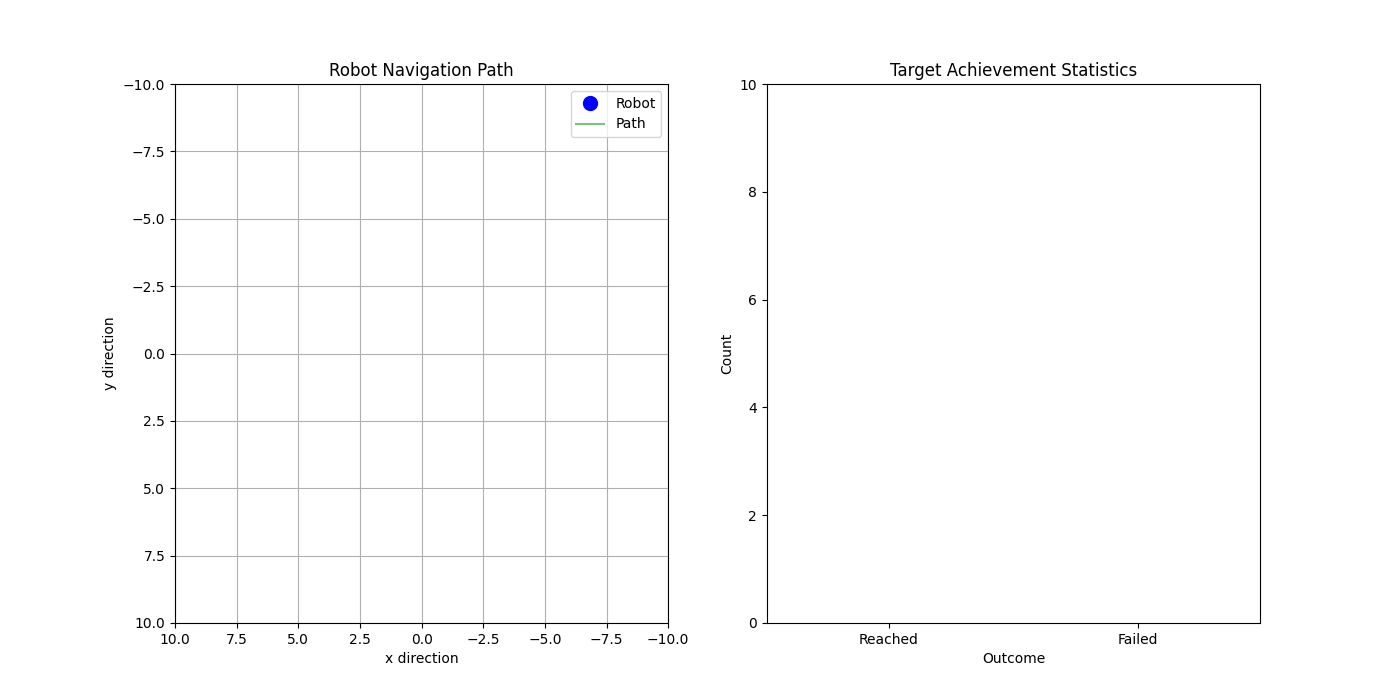

In [2]:
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Navigation plot
ax1.set_xlim(10, -10)
ax1.set_ylim(10, -10)
ax1.set_title("Robot Navigation Path")
ax1.set_xlabel("x direction")
ax1.set_ylabel("y direction")
ax1.grid(True)
robot_marker, = ax1.plot([], [], 'bo', markersize=10, label='Robot')
path_line, = ax1.plot([], [], 'g-', alpha=0.5, label='Path')
ax1.legend()

# Targets statistics plot
ax2.set_title("Target Achievement Statistics")
ax2.set_xlabel("Outcome")
ax2.set_ylabel("Count")
target_bars = ax2.bar(['Reached', 'Failed'], [0, 0], color=['green', 'red'])
ax2.set_ylim(0, 10)  # Initial limit, will auto-scale

### Widget Definitions 

In [3]:
# HTML Widgets
status_html = widgets.HTML(value="<b>Status:</b> Ready for new goal")
position_html = widgets.HTML(value="<b>Position:</b> X: 0.00 m, Y: 0.00 m")
velocity_html = widgets.HTML(value="<b>Velocity:</b> Linear: 0.00 m/s, Angular: 0.00 rad/s")
goal_html = widgets.HTML(value="<b>Current Goal:</b> None")
obstacle_html = widgets.HTML(value="<b>Closest Obstacle:</b> 0.00 m")
error_html = widgets.HTML(value="")
stats_html = widgets.HTML(value="<b>Target Stats:</b> Reached: 0, Failed: 0")

# Control widgets
target_x = widgets.IntSlider(value=0, min=-10, max=10, step=1, description='Target X:')
target_y = widgets.IntSlider(value=0, min=-10, max=10, step=1, description='Target Y:')
set_goal_button = widgets.Button(description="Set Goal", button_style='success')
cancel_button = widgets.Button(description="Cancel Goal", button_style='danger')

# Layout organization
controls = widgets.VBox([
    widgets.HBox([target_x]),
    widgets.HBox([target_y]),
    widgets.HBox([set_goal_button, cancel_button]),
    error_html,
    widgets.HTML("<h3>Robot Status</h3>"),
    status_html,
    goal_html,
    position_html, 
    velocity_html,
    obstacle_html,
    stats_html
])


### Callback Functions

In [4]:
def update_visualization(frame):
    """Update both plots using FuncAnimation"""
    # Update navigation plot
    if path_history:
        path_array = np.array(path_history)
        path_line.set_data(path_array[:,0], path_array[:,1])
    robot_marker.set_data([current_x], [current_y])
    
    # Update target statistics plot
    target_bars[0].set_height(reached_targets)
    target_bars[1].set_height(failed_targets)
    ax2.set_ylim(0, max(max(reached_targets, failed_targets) + 2, 5))
    
    return [robot_marker, path_line] + list(target_bars)

# Create animation
ani = FuncAnimation(fig, update_visualization, interval=100, blit=True, save_count=100)

# Odometry callback
def odom_callback(msg):
    global current_x, current_y, vel_x, vel_z, path_history, last_update_time
    
    current_x = msg.pose.pose.position.x
    current_y = msg.pose.pose.position.y
    vel_x = msg.twist.twist.linear.x
    vel_z = msg.twist.twist.angular.z
    
    # Throttle updates
    current_time = rospy.Time.now()
    if (current_time - last_update_time).to_sec() < 0.2:
        return
    last_update_time = current_time
    
    # Update path history
    path_history.append((current_x, current_y))
    if len(path_history) > path_history_max:
        path_history.pop(0)
    
    position_html.value = f"<b>Position:</b> X: {current_x:.2f} m, Y: {current_y:.2f} m"
    velocity_html.value = f"<b>Velocity:</b> Linear: {vel_x:.2f} m/s, Angular: {vel_z:.2f} rad/s"

# Lidar Scan
def scan_callback(msg):
    global closest_obstacle
    valid_ranges = [r for r in msg.ranges if msg.range_min < r < msg.range_max]
    if valid_ranges:
        closest_obstacle = min(valid_ranges)
        obstacle_html.value = f"<b>Closest Obstacle:</b> {closest_obstacle:.2f} m"

# Feedback callback
def feedback_callback(feedback):
    global goal_active, reached_targets, failed_targets
    
    if feedback.stat == "Target reached!":
        goal_active = False
        reached_targets += 1
        status_html.value = "<b>Status:</b> <span style='color:green'>Goal reached!</span>"
        goal_html.value = "<b>Current Goal:</b> None"
        stats_html.value = f"<b>Target Stats:</b> Reached: {reached_targets}, Failed: {failed_targets}"
    elif feedback.stat == "Goal cancelled":
        goal_active = False
        status_html.value = "<b>Status:</b> <span style='color:blue'>Goal cancelled</span>"
        goal_html.value = "<b>Current Goal:</b> None"
    else:
        status_html.value = f"<b>Status:</b> {feedback.stat}"

### Controls

In [5]:
# On set button press
def on_set_goal(b):
    global goal_active
    error_html.value = ""
    
    current_state = client.get_state()
    if current_state not in [GoalStatus.ACTIVE, GoalStatus.PENDING] and not goal_active:
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = float(target_x.value)
        goal.target_pose.pose.position.y = float(target_y.value)
        goal.target_pose.pose.orientation.w = 1.0
        
        client.send_goal(goal, feedback_cb=feedback_callback)
        goal_active = True
        goal_html.value = f"<b>Current Goal:</b> ({target_x.value}, {target_y.value})"
        status_html.value = "<b>Status:</b> <span style='color:blue'>Goal sent</span>"
    else:
        error_html.value = "<b>ERROR:</b> <span style='color:red'>Goal already active!</span>"

# On cancel button press
def on_cancel_goal(b):
    global goal_active, reached_targets, failed_targets
    current_state = client.get_state()
    
    if current_state in [GoalStatus.ACTIVE, GoalStatus.PENDING]:
        client.cancel_goal()
        goal_active = False
        status_html.value = "<b>Status:</b> <span style='color:red'>Cancellation requested</span>"
        failed_targets += 1
        stats_html.value = f"<b>Target Stats:</b> Reached: {reached_targets}, Failed: {failed_targets}"
    else:
        error_html.value = "<b>ERROR:</b> <span style='color:red'>No active goal to cancel</span>"


### ROS Setup and Execution

[INFO] [1746782192.627117, 2439.241000]: Jupyter interface ready!


HTML(value='<h3>Provide Goal </h3>')

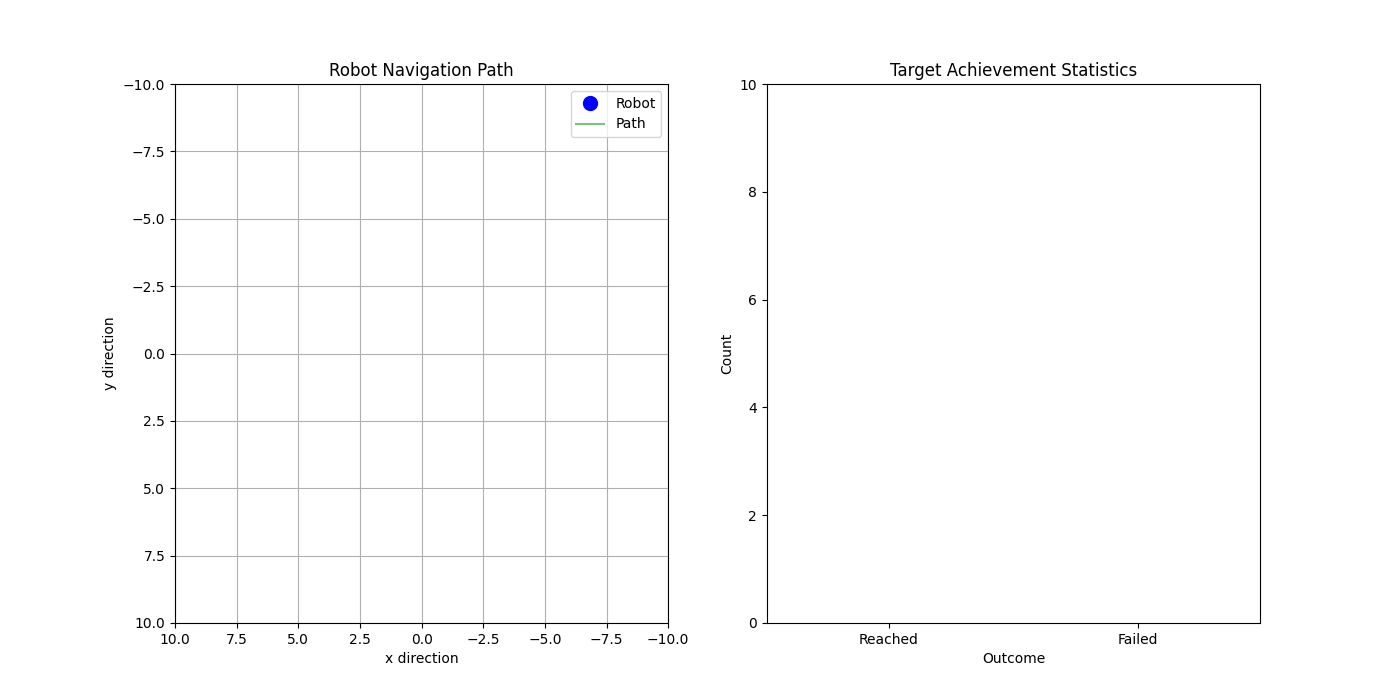

In [6]:
# Set up subscribers
rospy.Subscriber('/odom', Odometry, odom_callback)
rospy.Subscriber('/scan', LaserScan, scan_callback)

# Set up publisher
status_pub = rospy.Publisher('/robot_status', robot_status, queue_size=10)

# Set up callbacks
set_goal_button.on_click(on_set_goal)
cancel_button.on_click(on_cancel_goal)

# Publish status periodically
def publish_status():
    if not rospy.is_shutdown():
        msg = robot_status()
        msg.x = current_x
        msg.y = current_y
        msg.vel_x = vel_x
        msg.vel_z = vel_z
        status_pub.publish(msg)
        rospy.Timer(rospy.Duration(0.5), lambda e: publish_status(), oneshot=True)
        
publish_status()
rospy.loginfo("Jupyter interface ready!")
display(widgets.HTML("<h3>Provide Goal </h3>"),
    widgets.HBox([controls]),
       fig.canvas)